### Collaborative filtering recommendations

1. Import bibliotek

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import psycopg2
from sqlalchemy import create_engine, text

2. Wczytanie danych

In [3]:
path = 'C:\\Users\\aldabrow\\Desktop\\PowerBI Excercises\\INZ\\data\\archive\\'

In [4]:
# Connect to PostgreSQL server
host= "localhost"
database="movierecommenderdb"
user= "postgres"
password= "postgres"
port= "5432"


alchemyEngine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')
 
# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect()

# Read data from PostgreSQL database table and load into a DataFrame instance
query_movies = text('SELECT * FROM "Movies"')
query_ratings = text('SELECT * FROM "Ratings"')
df_movie = pd.read_sql_query(query_movies, dbConnection)
df_rating = pd.read_sql_query(query_ratings, dbConnection)

pd.set_option('display.expand_frame_repr', False)

# Close the database connectiona
dbConnection.close()

In [5]:
df_movie_evaluate = df_movie.copy()
df_movie_evaluate

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,poster_path,IMBD_poster_path,IMBD_backdrop_path
0,False,Toy Story Collection,30000000,"Animation, Comedy, Family",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,English,Released,None,Toy Story,False,7.7,5415.0,https://image.tmdb.org/t/p/original/uXDfjJbdP4...,https://image.tmdb.org/t/p/w500//7G9915LfUQ2lV...,https://image.tmdb.org/t/p/w500//9FBwqcd9IRruE...
1,False,None,65000000,"Adventure, Fantasy, Family",None,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"English, Français",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,https://image.tmdb.org/t/p/original/nLXYV4WmYU...,None,None
2,False,None,60000000,"Action, Crime, Drama, Thriller",None,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,"English, Español",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,https://image.tmdb.org/t/p/original/umSVjVdbVw...,None,None
3,False,James Bond Collection,58000000,"Adventure, Action, Thriller",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,"English, Pусский, Español",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,https://image.tmdb.org/t/p/original/z0ljRnNxIO...,https://image.tmdb.org/t/p/w500//HORpg5CSkmeQl...,https://image.tmdb.org/t/p/w500//6VcVl48kNKvdX...
4,False,None,98000000,"Action, Adventure",None,1408,tt0112760,en,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ...",...,"English, Latin",Released,The Course Has Been Set. There Is No Turning B...,Cutthroat Island,False,5.7,137.0,https://image.tmdb.org/t/p/original/8g4sF1Qthl...,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7404,False,None,0,"Comedy, Romance",None,98604,tt2147597,ru,Zolushka,"Masha Krapivina - is yet beautiful, and not th...",...,Pусский,Released,None,Cinderella,False,4.6,6.0,https://image.tmdb.org/t/p/original/nvGeucOZRf...,None,None
7405,False,None,0,"Music, Comedy, Family",None,5589,tt0232750,cs,Šíleně smutná princezna,No overview found.,...,Český,Released,None,Šíleně smutná princezna,False,6.1,4.0,https://image.tmdb.org/t/p/original/l0i8MtHc39...,None,None
7406,False,None,0,"Action, Mystery, Thriller, Horror",None,45527,tt1331329,en,The Final Storm,A stranger named Silas flees from a devastatin...,...,English,Released,"Action, Horror",The Final Storm,False,3.7,11.0,https://image.tmdb.org/t/p/original/6qud4ItaA6...,None,None
7407,False,None,0,"Fantasy, Action, Thriller",None,49280,tt0135453,fr,L'Homme orchestre,A band-leader has arranged seven chairs for th...,...,No Language,Released,None,The One-Man Band,False,6.5,22.0,https://image.tmdb.org/t/p/original/tZbhkqZK9x...,None,None


In [6]:
df_movie = df_movie[['movieId', 'title']]
df_movie.head()

,movieId,title
0,862,Toy Story
1,8844,Jumanji
2,949,Heat
3,710,GoldenEye
4,1408,Cutthroat Island


In [7]:
df_rating = df_rating.drop(columns=['timestamp'])
df_rating.head()

,userId,movieId,rating,normalized_rating,ratingID
0,24,2,3.0,0.555556,1
1,24,6,4.0,0.777778,2
2,24,16,3.0,0.555556,3
3,24,17,3.0,0.555556,4
4,24,21,4.0,0.777778,5


In [8]:
df_rating.shape

(4587483, 5)

3. Przygotowanie i czyszczenie danych

In [9]:
df_movie.shape

(7409, 2)

In [10]:
df_rating.shape

(4587483, 5)

In [11]:
#check unique movies
df_rating['movieId'].nunique()

7447

In [12]:
#merge the two dataframes on the movieId column and id column
df_movie_rating = pd.merge(df_rating, df_movie, on='movieId')
df_movie_rating.head()

,userId,movieId,rating,normalized_rating,ratingID,title
0,24,2,3.0,0.555556,1,Ariel
1,49,2,4.5,0.888889,597,Ariel
2,62,2,2.0,0.333333,770,Ariel
3,120,2,2.5,0.444444,1119,Ariel
4,191,2,3.0,0.555556,1925,Ariel


In [13]:
#check nan values in title column
df_movie_rating.isnull().sum()

userId               0
movieId              0
rating               0
normalized_rating    0
ratingID             0
title                0
dtype: int64

In [14]:
df_movie_rating.shape

(4497791, 6)

In [15]:
#check unique movies
df_movie_rating['movieId'].nunique()

7293

In [16]:
#check unique users
df_movie_rating['userId'].nunique()

16679

In [17]:
df_movie.set_index('movieId', inplace=True)
df_movie.head()

,title
movieId,
862,Toy Story
8844,Jumanji
949,Heat
710,GoldenEye
1408,Cutthroat Island


In [18]:
#save the dataframe as json file for later use, but take only unique values of title
import json
df_to_json = df_movie_rating.drop_duplicates(subset=['title'])
df_to_json = df_to_json[['movieId', 'title']]
df_to_json = df_to_json.to_dict(orient="records")

# Write the JSON data to a file
with open("C:\\Users\\aldabrow\\Desktop\\PowerBI Excercises\\INZ\\movies.json", "w") as json_file:
    json.dump(df_to_json, json_file, indent=4)

print("CSV data has been successfully converted to JSON.")

CSV data has been successfully converted to JSON.


4. EDA

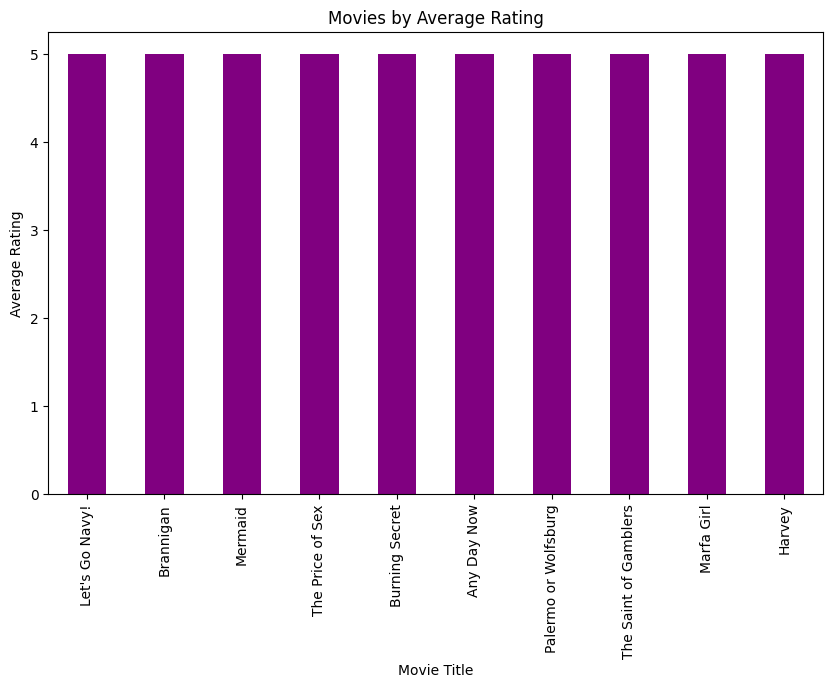

In [19]:
#movies by average rating
avarage_rating = df_movie_rating.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
avarage_rating.plot(kind='bar', color = 'purple')
plt.title('Movies by Average Rating')
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.show()


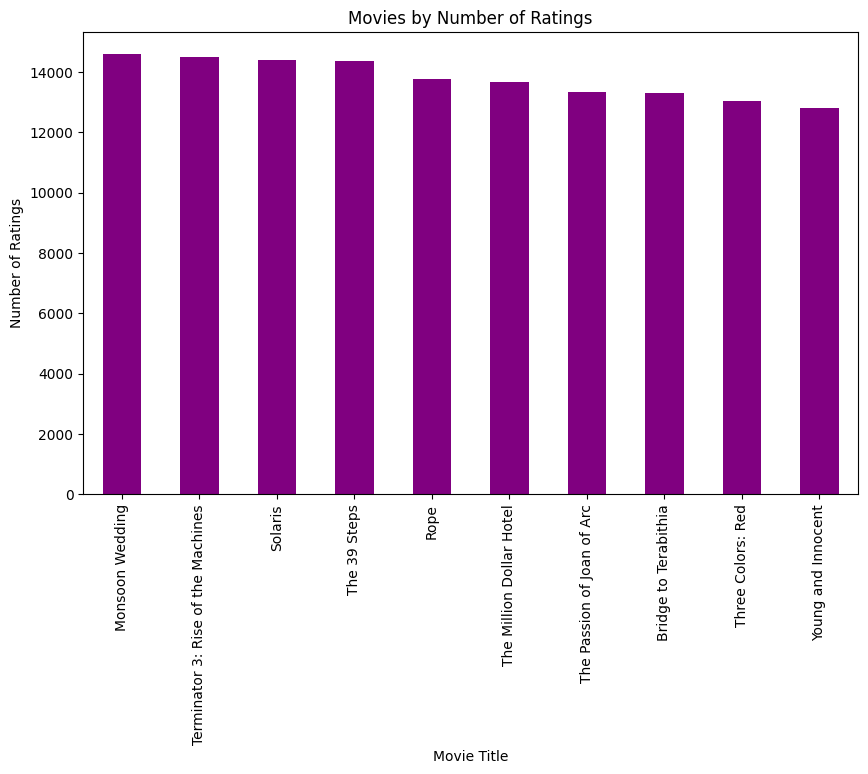

In [20]:
#movies by number of ratings
number_of_ratings = df_movie_rating.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
number_of_ratings.plot(kind='bar', color = 'purple')
plt.title('Movies by Number of Ratings')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.show()

5. Tabela przestawna item-user

In [21]:
#pivot the dataframe to get the movie titles as the columns and the userId as the rows and the ratings as the values
df_movie_rating_pivot = df_movie_rating.pivot_table(index='movieId', columns='userId', values='normalized_rating')
df_movie_rating_pivot.head()

userId,24,46,49,62,65,120,132,150,191,193,...,270734,270740,270746,270750,270759,270769,270807,270828,270879,270887
movieId,,,,,,,,,,,,,,,,,,,,,
2,0.555556,NaN,0.888889,0.333333,NaN,0.444444,NaN,NaN,0.555556,NaN,...,0.555556,NaN,0.444444,NaN,NaN,0.555556,NaN,0.333333,0.666667,1.000000
3,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.555556,0.777778,...,0.555556,0.777778,NaN,0.777778,NaN,0.111111,NaN,NaN,NaN,0.777778
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,NaN,0.444444,NaN,NaN,NaN,NaN,0.555556,NaN,NaN
6,0.777778,0.555556,NaN,NaN,1.000000,NaN,NaN,0.555556,1.000000,1.000000,...,NaN,NaN,NaN,0.777778,0.555556,0.555556,NaN,NaN,NaN,1.000000
11,NaN,NaN,NaN,NaN,0.555556,NaN,0.555556,0.555556,0.777778,NaN,...,1.000000,NaN,0.777778,0.777778,NaN,NaN,NaN,1.000000,NaN,0.777778


In [22]:
df_movie_rating_pivot.shape

(7293, 16679)

In [23]:
#fill the null values with 0
df_movie_rating_pivot = df_movie_rating_pivot.fillna(0)
df_movie_rating_pivot.head()

userId,24,46,49,62,65,120,132,150,191,193,...,270734,270740,270746,270750,270759,270769,270807,270828,270879,270887
movieId,,,,,,,,,,,,,,,,,,,,,
2,0.555556,0.000000,0.888889,0.333333,0.000000,0.444444,0.000000,0.000000,0.555556,0.000000,...,0.555556,0.000000,0.444444,0.000000,0.000000,0.555556,0.0,0.333333,0.666667,1.000000
3,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.555556,0.777778,...,0.555556,0.777778,0.000000,0.777778,0.000000,0.111111,0.0,0.000000,0.000000,0.777778
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.444444,0.000000,0.000000,0.000000,0.0,0.555556,0.000000,0.000000
6,0.777778,0.555556,0.000000,0.000000,1.000000,0.000000,0.000000,0.555556,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.777778,0.555556,0.555556,0.0,0.000000,0.000000,1.000000
11,0.000000,0.000000,0.000000,0.000000,0.555556,0.000000,0.555556,0.555556,0.777778,0.000000,...,1.000000,0.000000,0.777778,0.777778,0.000000,0.000000,0.0,1.000000,0.000000,0.777778


6. Miara podobieństwa

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
movie_similarity = cosine_similarity(df_movie_rating_pivot)
movie_similarity

array([[1.        , 0.42039357, 0.42159902, ..., 0.        , 0.        ,
        0.01358878],
       [0.42039357, 1.        , 0.46918904, ..., 0.        , 0.        ,
        0.        ],
       [0.42159902, 0.46918904, 1.        , ..., 0.        , 0.01324867,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01324867, ..., 0.        , 1.        ,
        0.        ],
       [0.01358878, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [25]:
similar_movies_df = pd.DataFrame(movie_similarity, index=df_movie_rating_pivot.index, columns=df_movie_rating_pivot.index)
similar_movies_df.head()

movieId,2,3,5,6,11,12,13,14,15,16,...,175791,175869,175983,176037,176069,176077,176085,176143,176167,176273
movieId,,,,,,,,,,,,,,,,,,,,,
2,1.000000,0.420394,0.421599,0.468968,0.431498,0.275439,0.250235,0.195239,0.291855,0.450507,...,0.008699,0.0,0.001941,0.0,0.013589,0.0,0.01553,0.0,0.000000,0.013589
3,0.420394,1.000000,0.469189,0.354081,0.432729,0.250401,0.132893,0.217507,0.244821,0.360542,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000
5,0.421599,0.469189,1.000000,0.298018,0.438375,0.233665,0.169059,0.199079,0.226497,0.292898,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.013249,0.000000
6,0.468968,0.354081,0.298018,1.000000,0.430432,0.194774,0.108449,0.303765,0.247175,0.674481,...,0.014829,0.0,0.009652,0.0,0.011260,0.0,0.00000,0.0,0.000000,0.000000
11,0.431498,0.432729,0.438375,0.430432,1.000000,0.177619,0.152013,0.317608,0.248288,0.412264,...,0.021738,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000


7. Rekomendacje

In [26]:
def get_IBCF_movie_recommendations(movie_name, top_n=30):
    target_movie = df_movie[df_movie['title'] == movie_name]
    #print(target_movie)
    if not target_movie.empty:
        target_movie_id = df_movie[df_movie['title'] == movie_name].index[0]
        print(target_movie_id)
        similar_movies = similar_movies_df[target_movie_id].sort_values(ascending=False)
        #print(similar_movies)
        similar_movies = similar_movies.drop(target_movie_id)  # Remove the target movie
        #print(similar_movies)
        top_similar_movies = similar_movies.head(top_n)
        #print(top_similar_movies)   
        
        recommendations_df = pd.DataFrame({
            'title': df_movie['title'].loc[top_similar_movies.index],
            'similarity_score': top_similar_movies.values
        })
        
        # Reset the index to make 'movieId' a regular column
        recommendations_df.reset_index(inplace=True)
        
        return recommendations_df
    else:
        return "Movie not found in the dataset."

In [27]:
movie_name = "Toy Story"
recommendations = get_IBCF_movie_recommendations(movie_name)
print("Recommended Movies for", movie_name)
recommendations

862
Recommended Movies for Toy Story


,movieId,title,similarity_score
0,55,Amores perros,0.217309
1,803,Night and Fog,0.214010
2,1392,Born into Brothels,0.212793
3,2486,Eragon,0.205740
4,523,Requiem,0.197737
5,988,The China Syndrome,0.188100
6,187,Sin City,0.187688
7,764,The Evil Dead,0.187174
8,82,Miami Vice,0.185195
9,35,The Simpsons Movie,0.184829


In [28]:
get_IBCF_movie_recommendations("Toy Story")['title'].to_list()

862


['Amores perros',
 'Night and Fog',
 'Born into Brothels',
 'Eragon',
 'Requiem',
 'The China Syndrome',
 'Sin City',
 'The Evil Dead',
 'Miami Vice',
 'The Simpsons Movie',
 'Wild at Heart',
 'Raiders of the Lost Ark',
 'Die Hard',
 'Small Change',
 'Paradise Now',
 'Catwoman',
 'The Tailor of Panama',
 'Berlin is in Germany',
 'Army of Darkness',
 'The Deathmaker',
 'Hotel Rwanda',
 'Fried Green Tomatoes',
 "Pan's Labyrinth",
 'The Killing',
 'Dances with Wolves',
 'Straw Dogs',
 'Wet Hot American Summer',
 'Braveheart',
 'Wings of Desire',
 'Open Water']

In [29]:
def evaluate_IBCF_recommendations(user_id, recommended_movies, ratings_df):
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    #print(user_ratings.head())
    # Filter the user's ratings for the recommended movies
    user_ratings = user_ratings[user_ratings['title'].isin(recommended_movies)]
    #print(user_ratings)
    
    if user_ratings.empty:
        return 0.0, 0.0
    
    true_ratings = user_ratings['normalized_rating']
    #print(true_ratings)
    predicted_ratings = user_ratings.apply(lambda row: 1.0 if row['title'] in recommended_movies else 0.0, axis=1)
    #print(predicted_ratings)
    mse = mean_squared_error(true_ratings, predicted_ratings)
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    
    return mse, mae

In [30]:
def evaluation(user_id):
    user_ratings = df_movie_rating[df_movie_rating['userId'] == user_id]
    #print(f"User {user_id} has rated {user_ratings.shape[0]} movies.")
    mse_error = []
    mae_error = []

    for idx, row in user_ratings.iterrows():
        movie_id = row['movieId']
        #print(movie_id)
        movie_title = df_movie_evaluate[df_movie_evaluate['movieId'] == movie_id]['title'].values[0]
        #print(movie_title)
        recommended_movies = get_IBCF_movie_recommendations(movie_title)['title'].to_list()
        mse, mae = evaluate_IBCF_recommendations(user_id, recommended_movies, df_movie_rating)
        mse_error.append(mse)
        mae_error.append(mae)
        
    return mse_error, mae_error

In [31]:
# Example usage for a user with userId 24
user_id = 45811
mse_error, mae_error = evaluation(user_id)
print(f"Average MSE error for user {user_id}: {np.mean(mse_error)}")
print(f"Average MAE error for user {user_id}: {np.mean(mae_error)}")

2
6
16
17
21
25


58
73
101
110
111
112
162
164
175
176
194
198
232
233
235
246
260
261
265
266
293
296
299
300
307
318
319
337
349
377
428
431
441
454
457
471
480
481
482
497
507
508
524
527
541
550
553
562
574
587
588
590
592
593
595
597
608
648
714
778
781
788
832
858
924
994
1073
1088
1089
1090
1125
1127
1213
1245
1246
1247
1249
1257
1259
1265
1266
1268
1271
1272
1358
1370
1378
1387
1393
1394
1408
1542
1580
1587
1594
1600
1610
1611
1619
1649
1653
1673
1721
1729
1735
1777
1810
1836
1912
1914
1921
1923
1947
1954
1956
1958
1959
1961
1963
1968
1969
1970
1976
1977
1978
1979
1984
1985
1994
2000
2001
2003
2005
2006
2011
2012
2021
2028
2054
2064
2072
2100
2105
2109
2115
2122
2144
2161
2193
2268
2289
2291
2294
2295
2302
2321
2324
2331
2333
2348
2355
2371
2395
2460
2470
2517
2640
2657
2671
2687
2692
2701
2758
2762
2791
2890
2926
2959
2976
2989
2990
3033
3040
3052
3060
3072
3074
3081
3101
3102
3114
3160
3168
3175
3178
3210
3396
3418
3476
3489
3526
3527
3543
3556
3635
3682
3683
3698
3699
4031
4034
19
63
65
69
7

8. Algorytm najbliższego sąsiedztwa

In [32]:
#apply k nearest neighbors to find the most similar movies
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute', n_jobs=-1)
knn.fit(df_movie_rating_pivot.values)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [33]:
#get recommendations
def get_movie_recommendations_knn(movie_name, top_n=30):
    target_movie = df_movie[df_movie['title'] == movie_name]
    #print(target_movie)
    if not target_movie.empty:
        target_movie_id = df_movie[df_movie['title'] == movie_name].index[0]
        #print(target_movie_id)
        #print(df_movie_rating_pivot.values[target_movie_id].reshape(1, -1))
        #take the row of the target movie and reshape it to 2d array
        print(df_movie_rating_pivot.values[target_movie_id].reshape(1, -1).shape)
        
        distances, indices = knn.kneighbors(df_movie_rating_pivot.loc[target_movie_id].values.reshape(1, -1), n_neighbors=top_n)
        #print(distances, indices)
        similarity_score = 1 - distances.flatten()
        #take the indices and check movie ids from the pivot table
        #print(df_movie_rating_pivot.iloc[indices[0]]) 
        #take only movie id column and convert it to list
        #print(df_movie_rating_pivot.iloc[indices[0]].index.tolist())
        
        #now take the movie ids and find the movie titles from the movie dataframe
        recommendations_df = pd.DataFrame({
            'title': df_movie['title'].loc[df_movie_rating_pivot.iloc[indices[0]].index.tolist()][1:],
            'distance': similarity_score[1:]
        })
        
        recommendations_df = recommendations_df.sort_values(by='distance', ascending=False)
        
        # Reset the index to make 'movieId' a regular column
        recommendations_df.reset_index(inplace=True)
        
        return recommendations_df
    else:
        return "Movie not found in the dataset."
    
movie_name = "Toy Story"
recommendations = get_movie_recommendations_knn(movie_name)
print("Recommended Movies for", movie_name)
recommendations

(1, 16679)
Recommended Movies for Toy Story


,movieId,title,distance
0,55,Amores perros,0.217309
1,803,Night and Fog,0.214010
2,1392,Born into Brothels,0.212793
3,2486,Eragon,0.205740
4,523,Requiem,0.197737
5,988,The China Syndrome,0.188100
6,187,Sin City,0.187688
7,764,The Evil Dead,0.187174
8,82,Miami Vice,0.185195
9,35,The Simpsons Movie,0.184829


In [34]:
#get movie title from movie id
df_movie.loc[2]['title']

'Ariel'

In [35]:
df_movie_rating_pivot.shape

(7293, 16679)

In [36]:
#get knn recommendations for a group of movies
def get_group_recommendations(movie_names, top_n=50):
    movie_ids = []
    for movie_name in movie_names:
        movie_id = df_movie[df_movie['title'] == movie_name].index[0]
        movie_ids.append(movie_id)
    
    print(movie_ids)
    #print(df_movie_rating_pivot.loc[movie_ids])
    #print(df_movie_rating_pivot.loc[movie_ids].values)
    #print(df_movie_rating_pivot.loc[movie_ids].values.sum(axis=0))
    print(df_movie_rating_pivot.loc[movie_ids].values.sum(axis=0).reshape(1, -1).shape)
    distances, indices = knn.kneighbors(df_movie_rating_pivot.loc[movie_ids].values.sum(axis=0).reshape(1, -1), n_neighbors=top_n)
    #print(distances, indices)
    similarity_score = 1 - distances.flatten()
    #print(df_movie_rating_pivot.iloc[indices[0]].index.tolist())
    
    recommendations_df = pd.DataFrame({
        'title': df_movie['title'].loc[df_movie_rating_pivot.iloc[indices[0]].index.tolist()][1:],
        'distance': similarity_score[1:],
    })
    
    recommendations_df = recommendations_df.sort_values(by='distance', ascending=False)
    
    # Reset the index to make 'movieId' a regular column
    recommendations_df.reset_index(inplace=True)
    
    return recommendations_df

movie_names = ['Toy Story', 'Ariel', 'Jumanji']
recommendations = get_group_recommendations(['Toy Story', 'Ariel'])
print("Recommended Movies for", movie_names)
recommendations

[862, 2]
(1, 16679)


Recommended Movies for ['Toy Story', 'Ariel', 'Jumanji']


,movieId,title,distance
0,480,Monsoon Wedding,0.715541
1,364,Batman Returns,0.698317
2,780,The Passion of Joan of Arc,0.690073
3,1580,Rope,0.676189
4,500,Reservoir Dogs,0.675354
5,586,Wag the Dog,0.673859
6,588,Silent Hill,0.673382
7,648,Beauty and the Beast,0.653855
8,377,A Nightmare on Elm Street,0.652388
9,260,The 39 Steps,0.650814


In [37]:
def evaluation_knn(user_id):
    user_ratings = df_movie_rating[df_movie_rating['userId'] == user_id]
    #print(f"User {user_id} has rated {user_ratings.shape[0]} movies.")
    mse_error = []
    mae_error = []

    for idx, row in user_ratings.iterrows():
        movie_id = row['movieId']
        #print(movie_id)
        movie_title = df_movie_evaluate[df_movie_evaluate['movieId'] == movie_id]['title'].values[0]
        #print(movie_title)
        recommended_movies = get_movie_recommendations_knn(movie_title)['title'].to_list()
        mse, mae = evaluate_IBCF_recommendations(user_id, recommended_movies, df_movie_rating)
        mse_error.append(mse)
        mae_error.append(mae)
        
    return mse_error, mae_error

In [38]:
user_id = 45811
mse_error, mae_error = evaluation_knn(user_id)
print(f"Average MSE error for user {user_id}: {np.mean(mse_error)}")
print(f"Average MAE error for user {user_id}: {np.mean(mae_error)}")

(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)
(1, 16679)

IndexError: index 7454 is out of bounds for axis 0 with size 7293